In [1]:
!pip3 install torchgan

In [0]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
# Pytorch and Torchvision Imports
import torch
import torchvision
from torch.optim import Adam
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as data
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils
# Torchgan Imports
from torchgan.losses import MinimaxGeneratorLoss, MinimaxDiscriminatorLoss
import torchgan
from torchgan.layers import SpectralNorm2d, SelfAttention2d, ResidualBlock2d
from torchgan.models import Generator, Discriminator
from torchgan.losses import WassersteinGeneratorLoss, WassersteinDiscriminatorLoss, WassersteinGradientPenalty
from torchgan.trainer import Trainer

from google.colab.patches import cv2_imshow
import cv2


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip -q /content/drive/My\ Drive/churches.zip 

replace Храмы/-JD3BVv5dOmXkA89sGJhBQbwa3comdeuZZEW006WXgbhDOKDqPMlNxNe4-UnpijswSBbsLtfL5EYs0Iliqat_OXQ83wTqUmcs9FXGMEc.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
def church_loader(data_size=512):
  for root, dirs, files in os.walk("../content/Храмы/"):
      res = np.zeros((data_size, 3,64,64))
      ex_count = 0
      for i, file in enumerate(files):
        
     
        if file.endswith(".jpg"):
             image=cv2.imread(root+file)
             try:
                image.resize(3,64,64)
                image = image/ 127.5 - 1.
                res[i,:,:,:] = image
             except AttributeError:
                ex_count+=1
                pass
             
        if i > data_size-2 : 
          print(ex_count)
          print(len(files))
          features = torch.from_numpy(res)
          features = features.float()
          targets = torch.ones(data_size)
          train_tensor = data.TensorDataset(features, targets)
          train_loader = data.DataLoader(train_tensor, batch_size=256, shuffle=True)
          return train_loader

In [0]:
# sample = cv2.imread('images/epoch1_generator.png')
# sample

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    # Use deterministic cudnn algorithms
    torch.backends.cudnn.deterministic = True
    epochs = 20
else:
    device = torch.device("cpu")
    epochs = 10

print("Device: {}".format(device))
print("Epochs: {}".format(epochs))

Device: cuda:0
Epochs: 20


In [0]:
class ResDown(nn.Module):
  def __init__(self, input_channels, output_channels):
    super(ResDown, self).__init__()
   
    self.skip = nn.Sequential(
                  nn.Conv2d(input_channels, output_channels, 1),
                  nn.AvgPool2d(2))
    self.model = nn.Sequential(
                nn.LeakyReLU(0.2),
                nn.Conv2d(input_channels, output_channels, 3,1,1),
                nn.LeakyReLU(0.2),
                nn.Conv2d(output_channels, output_channels, 3,1,1),
                nn.AvgPool2d(2))
  def forward(self, x):
    main = self.model(x)
    skip = self.skip(x)
    out = torch.add(skip, main)
    return out

In [0]:
class BigGanDiscriminator(Discriminator):
    def __init__(self, chn=64):
        super(BigGanDiscriminator, self).__init__(3, 'none')
        self.pre_conv = nn.Sequential(SpectralNorm2d(nn.Conv2d(3, chn, 3,1,1)),
                                      nn.ReLU(),
                                      SpectralNorm2d(nn.Conv2d(chn, chn, 3,1,1)),
                                      nn.AvgPool2d(2))
        self.pre_skip = SpectralNorm2d(nn.Conv2d(3, chn, 1))

        self.conv = nn.Sequential(ResDown(chn, chn),
                                  SelfAttention2d(chn),
                                  ResDown(chn, 2*chn),    
                                  ResDown(2*chn, 4*chn),
                                  ResDown(4*chn, 8*chn)
#                                   ,
#                                   ResDown(8*chn, 16*chn)
                                 )
        self.res_layer = ResidualBlock2d([8*chn, 8*chn], [3], [1],[1])
        self.linear = SpectralNorm2d(nn.Linear(8*chn, 1))

        self.last = nn.LeakyReLU(0.2)
    def forward(self, x):
      out = self.pre_conv(x)
      out = out + self.pre_skip(F.avg_pool2d(x, 2))
      out = self.conv(out)
      out = self.res_layer(out)
      out = out.view(out.size(0), out.size(1), -1)
      out = out.sum(2)
      out = self.linear(out)
      out = self.last(out)
      
      return out

In [0]:
class ResUp(nn.Module):
  def __init__(self, input_channels, output_channels):
    super(ResUp, self).__init__()
    self.skip =  nn.Conv2d(input_channels , output_channels, 1)
    self.model_1 = nn.Sequential(nn.BatchNorm2d(input_channels), nn.LeakyReLU(0.2))
    self.model_2 = nn.Sequential(              
                nn.Conv2d(input_channels, output_channels , 3,1,1),
                nn.BatchNorm2d(output_channels), nn.LeakyReLU(0.2),
                nn.Conv2d(output_channels, output_channels, 3,1,1))
  def forward(self, x):
    main = self.model_1(x)
 
    main = F.upsample(main, scale_factor=2)
   
    main = self.model_2(main)
    skip = F.upsample(self.skip(x), scale_factor=2)
    out = torch.add(main, skip)
    return out


In [0]:
class BigGanGenerator(Generator):
    def __init__(self, chn=64):
        super(BigGanGenerator, self).__init__(2000, 'none')
        self.chn = chn
        
        self.linear = SpectralNorm2d(nn.Linear(2000, 4 * 4 * 16 * chn))
        self.conv = nn.Sequential(
#                                 ResUp(16*chn, 16*chn),
                               
                                ResUp(16*chn, 8*chn),
                                
                                ResUp(8*chn, 4*chn),
                                
                                ResUp(4*chn, 2*chn),
                                
                                SelfAttention2d(2*chn),
                                ResUp(2*chn, chn)
                              
                                )
        self.last = nn.Sequential(nn.BatchNorm2d(chn), nn.LeakyReLU(0.2),
                nn.Conv2d(chn, 3, 1), nn.Tanh())
    def forward(self, x):

        out = self.linear(x)
        out = out.view(-1, 16*self.chn, 4, 4)
        out = self.conv(out)
        out = self.last(out)
        return out

In [0]:
def img_show(k):
  for i in range(k*2 +1,k*2+3):
#     x = torch.randn(1, 1000).float().cuda()
#     res = trainer.generator.forward(x)
#     res = res.cpu().detach().numpy()    
#     res = res.reshape(64,64,3)
#     res_test = (res+1)*127.5
#     img = res_test.astype(np.uint8)
#     img = cv2.resize(img, dsize=(192, 192), interpolation=cv2.INTER_CUBIC)
#     cv2_imshow(img)
    path = 'images/epoch' + str(i) + '_generator.png'
    print(path)
    sample = cv2.imread(path)
    
    cv2_imshow(sample)
   

In [0]:
network_params = {
    "generator": {"name": BigGanGenerator, "args": {"chn": 64},
                  "optimizer": {"name": Adam, "args": {"lr": 0.0001, "betas": (0.5, 0.999)}}},
    "discriminator": {"name": BigGanDiscriminator, "args": {"chn": 64},
                      "optimizer": {"name": Adam, "args": {"lr": 0.0004, "betas": (0.5, 0.999)}}}
}

In [0]:
trainer = Trainer(network_params, [MinimaxGeneratorLoss(), MinimaxDiscriminatorLoss()], sample_size=32, epochs=2, device=device, retain_checkpoints = 1, checkpoints = "/content/drive/My Drive/big_small__gan" )

In [0]:
# trainer.load_model('../content/drive/My Drive/big_small__gan0.model')

0
5544


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 1 Summary
generator Mean Gradients : 0.5595394623870535
discriminator Mean Gradients : 73.37760581773318
Mean Running Discriminator Loss : 1.3651411641727795
Mean Running Generator Loss : 1.0345700870860706
Generating and Saving Images to ./images/epoch1_generator.png

Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 2 Summary
generator Mean Gradients : 0.4250317162653886
discriminator Mean Gradients : 383.7855321427964
Mean Running Discriminator Loss : 1.7225779349153691
Mean Running Generator Loss : 0.995569633277393
Generating and Saving Images to ./images/epoch2_generator.png

Training of the Model is Complete
images/epoch1_generator.png


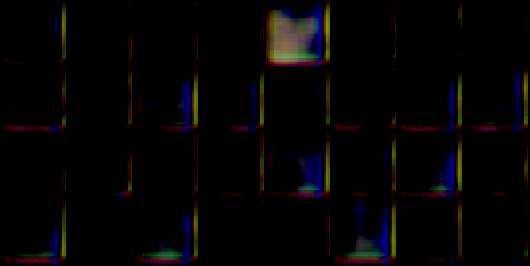

images/epoch2_generator.png


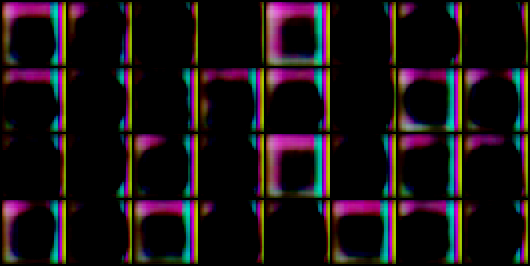

0
5544
Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 1 Summary
generator Mean Gradients : 0.7901375103814398
discriminator Mean Gradients : 278.8597139496659
Mean Running Discriminator Loss : 1.6160646550583118
Mean Running Generator Loss : 1.0773035408362899
Generating and Saving Images to ./images/epoch3_generator.png

Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 2 Summary
generator Mean Gradients : 1.4850669840159212
discriminator Mean Gradients : 516.4732819008549
Mean Running Discriminator Loss : 1.5621890283443711
Mean Running Generator Loss : 1.1174492925742925
Generating and Saving Images to ./images/epoch4_generator.png

Training of the Model is Complete
images/epoch3_generator.png


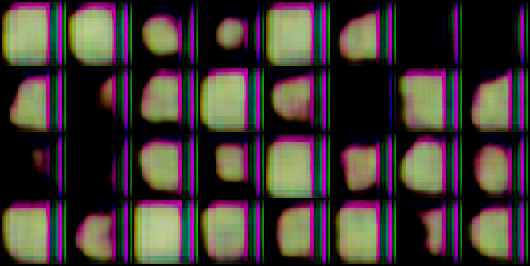

images/epoch4_generator.png


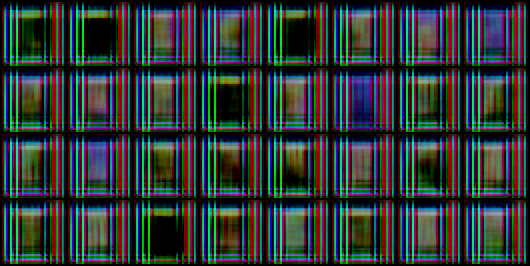

0
5544
Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 1 Summary
generator Mean Gradients : 1.2898136094810413
discriminator Mean Gradients : 496.2722374797643
Mean Running Discriminator Loss : 1.5654520386999304
Mean Running Generator Loss : 1.1225688397883378
Generating and Saving Images to ./images/epoch5_generator.png

Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 2 Summary
generator Mean Gradients : 1.2382310052359509
discriminator Mean Gradients : 440.43919076007575
Mean Running Discriminator Loss : 1.5347787390152614
Mean Running Generator Loss : 1.1183852332107123
Generating and Saving Images to ./images/epoch6_generator.png

Training of the Model is Complete
images/epoch5_generator.png


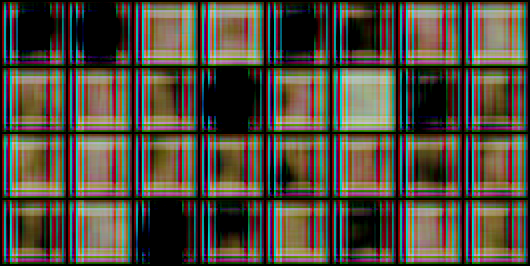

images/epoch6_generator.png


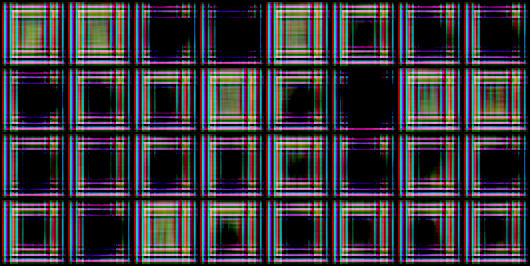

0
5544
Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 1 Summary
generator Mean Gradients : 1.2403005162707543
discriminator Mean Gradients : 384.3583827410104
Mean Running Discriminator Loss : 1.484913667301079
Mean Running Generator Loss : 1.086548484765019
Generating and Saving Images to ./images/epoch7_generator.png

Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 2 Summary
generator Mean Gradients : 1.243606097258211
discriminator Mean Gradients : 354.0183436148747
Mean Running Discriminator Loss : 1.4362535060129382
Mean Running Generator Loss : 1.0797737179831406
Generating and Saving Images to ./images/epoch8_generator.png

Training of the Model is Complete
images/epoch7_generator.png


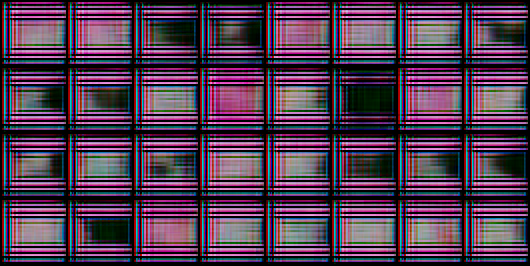

images/epoch8_generator.png


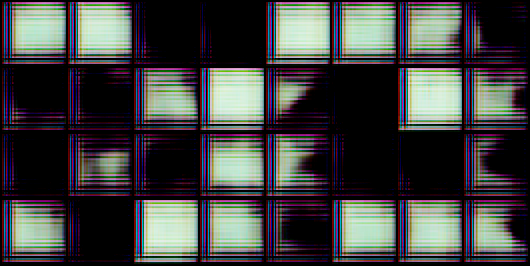

0
5544
Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 1 Summary
generator Mean Gradients : 1.546037118263859
discriminator Mean Gradients : 320.542551341472
Mean Running Discriminator Loss : 1.308296870101582
Mean Running Generator Loss : 1.1471737701482896
Generating and Saving Images to ./images/epoch9_generator.png

Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 2 Summary
generator Mean Gradients : 1.7694912106770657
discriminator Mean Gradients : 290.8797730011671
Mean Running Discriminator Loss : 1.1895839724351058
Mean Running Generator Loss : 1.2749267502264048
Generating and Saving Images to ./images/epoch10_generator.png

Training of the Model is Complete
images/epoch9_generator.png


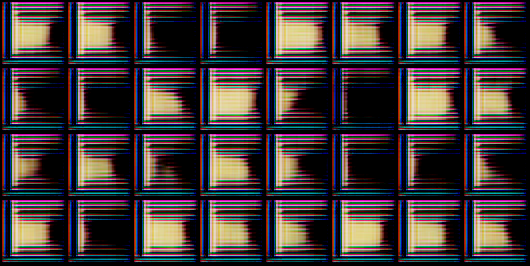

images/epoch10_generator.png


0
5544
Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 1 Summary
generator Mean Gradients : 1.8648156454182625
discriminator Mean Gradients : 266.4545935585892
Mean Running Discriminator Loss : 1.0889725362004574
Mean Running Generator Loss : 1.4136869936934722
Generating and Saving Images to ./images/epoch11_generator.png

Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 2 Summary
generator Mean Gradients : 1.9302799544233171
discriminator Mean Gradients : 245.39048825055283
Mean Running Discriminator Loss : 1.0027113635953742
Mean Running Generator Loss : 1.5647720261053193
Generating and Saving Images to ./images/epoch12_generator.png

Training of the Model is Complete
images/epoch11_generator.png


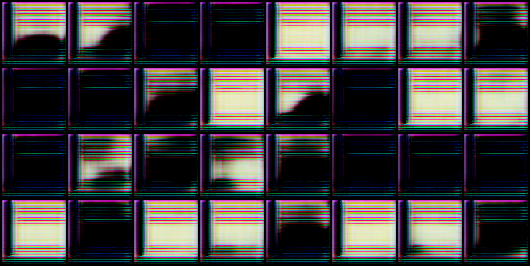

images/epoch12_generator.png


0
5544
Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 1 Summary
generator Mean Gradients : 18946.218888198375
discriminator Mean Gradients : 4072120.6690571597
Mean Running Discriminator Loss : 33.91650773212965
Mean Running Generator Loss : 30.357066777163517
Generating and Saving Images to ./images/epoch13_generator.png

Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 2 Summary
generator Mean Gradients : 17598.625292481036
discriminator Mean Gradients : 3782733.4061853676
Mean Running Discriminator Loss : 31.897906753857463
Mean Running Generator Loss : 28.55962695293851
Generating and Saving Images to ./images/epoch14_generator.png

Training of the Model is Complete
images/epoch13_generator.png


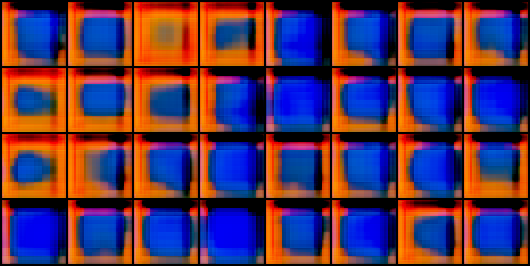

images/epoch14_generator.png


0
5544
Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 1 Summary
generator Mean Gradients : 16429.279002561194
discriminator Mean Gradients : 3531319.624483014
Mean Running Discriminator Loss : 29.809450726510224
Mean Running Generator Loss : 26.744743649672795
Generating and Saving Images to ./images/epoch15_generator.png

Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 2 Summary
generator Mean Gradients : 15413.095039414167
discriminator Mean Gradients : 3311267.384083764
Mean Running Discriminator Loss : 27.956302423183594
Mean Running Generator Loss : 25.225704220345804
Generating and Saving Images to ./images/epoch16_generator.png

Training of the Model is Complete
images/epoch15_generator.png


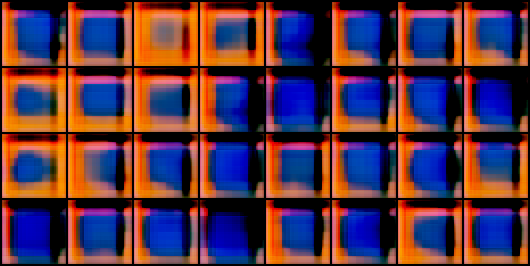

images/epoch16_generator.png


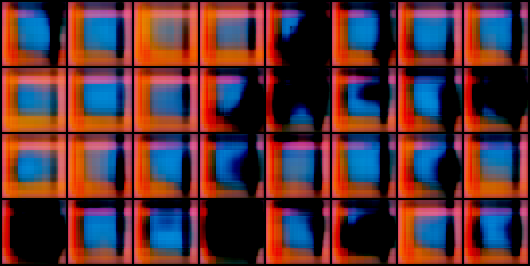

0
5544
Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 1 Summary
generator Mean Gradients : 14514.951472662047
discriminator Mean Gradients : 3117139.811355845
Mean Running Discriminator Loss : 26.33857175321841
Mean Running Generator Loss : 23.84440938655264
Generating and Saving Images to ./images/epoch17_generator.png

Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 2 Summary
generator Mean Gradients : 13711.40082690607
discriminator Mean Gradients : 2944407.8900188194
Mean Running Discriminator Loss : 24.886967377497278
Mean Running Generator Loss : 22.622450954205508
Generating and Saving Images to ./images/epoch18_generator.png

Training of the Model is Complete
images/epoch17_generator.png


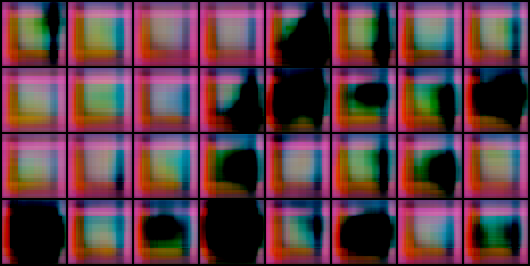

images/epoch18_generator.png


0
5544
Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 1 Summary
generator Mean Gradients : 12992.16170603749
discriminator Mean Gradients : 2789812.7179582343
Mean Running Discriminator Loss : 23.58498930400371
Mean Running Generator Loss : 21.54724764521788
Generating and Saving Images to ./images/epoch19_generator.png

Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 2 Summary
generator Mean Gradients : 12344.584452801753
discriminator Mean Gradients : 2650641.417934877
Mean Running Discriminator Loss : 22.411746745662423
Mean Running Generator Loss : 20.589137613612458
Generating and Saving Images to ./images/epoch20_generator.png

Training of the Model is Complete
images/epoch19_generator.png


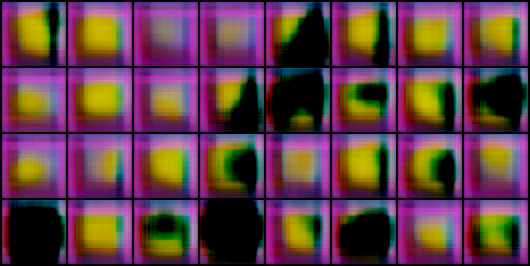

images/epoch20_generator.png


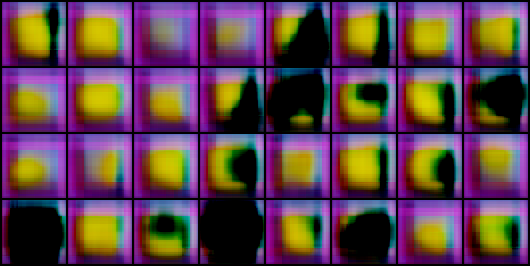

0
5544
Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 1 Summary
generator Mean Gradients : 11758.661991504146
discriminator Mean Gradients : 2524695.7431965023
Mean Running Discriminator Loss : 21.349407943784062
Mean Running Generator Loss : 19.729028967914683
Generating and Saving Images to ./images/epoch21_generator.png

Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 2 Summary
generator Mean Gradients : 11225.738813651435
discriminator Mean Gradients : 2410176.1525008716
Mean Running Discriminator Loss : 20.383568264178408
Mean Running Generator Loss : 18.94728165801058
Generating and Saving Images to ./images/epoch22_generator.png

Training of the Model is Complete
images/epoch21_generator.png


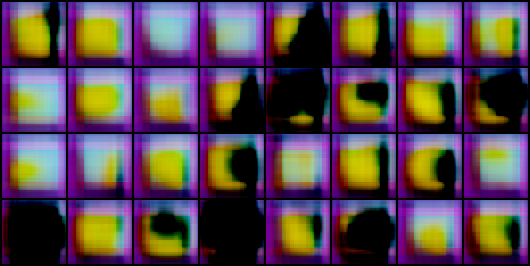

images/epoch22_generator.png


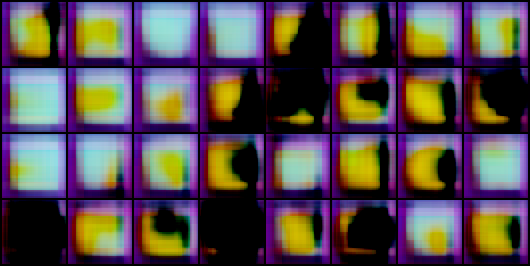

0
5544
Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 1 Summary
generator Mean Gradients : 10738.875893040387
discriminator Mean Gradients : 2305596.09438925
Mean Running Discriminator Loss : 19.501345861000065
Mean Running Generator Loss : 18.238009679318925
Generating and Saving Images to ./images/epoch23_generator.png

Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 2 Summary
generator Mean Gradients : 10292.441722491838
discriminator Mean Gradients : 2209718.434318781
Mean Running Discriminator Loss : 18.6927631369291
Mean Running Generator Loss : 17.588407184455917
Generating and Saving Images to ./images/epoch24_generator.png

Training of the Model is Complete
images/epoch23_generator.png


images/epoch24_generator.png


0
5544
Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 1 Summary
generator Mean Gradients : 9881.591079087399
discriminator Mean Gradients : 2121490.4872479276
Mean Running Discriminator Loss : 17.947638451263987
Mean Running Generator Loss : 17.002095520150913
Generating and Saving Images to ./images/epoch25_generator.png

Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 2 Summary
generator Mean Gradients : 9502.269640747794
discriminator Mean Gradients : 2040037.4259415509
Mean Running Discriminator Loss : 17.259601343406846
Mean Running Generator Loss : 16.46428809995546
Generating and Saving Images to ./images/epoch26_generator.png

Training of the Model is Complete
images/epoch25_generator.png


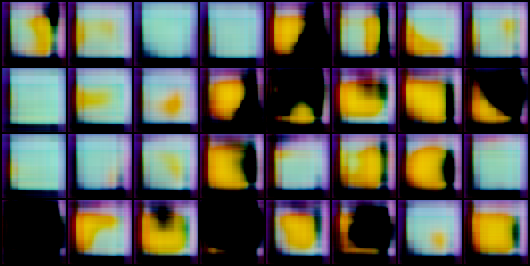

images/epoch26_generator.png


0
5544
Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 1 Summary
generator Mean Gradients : 9150.991011950302
discriminator Mean Gradients : 1964607.7784949515
Mean Running Discriminator Loss : 16.622387076345483
Mean Running Generator Loss : 15.969554239532794
Generating and Saving Images to ./images/epoch27_generator.png

Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 2 Summary
generator Mean Gradients : 8824.758952339038
discriminator Mean Gradients : 1894557.207888403
Mean Running Discriminator Loss : 16.03055414763376
Mean Running Generator Loss : 15.511883048540229
Generating and Saving Images to ./images/epoch28_generator.png

Training of the Model is Complete
images/epoch27_generator.png


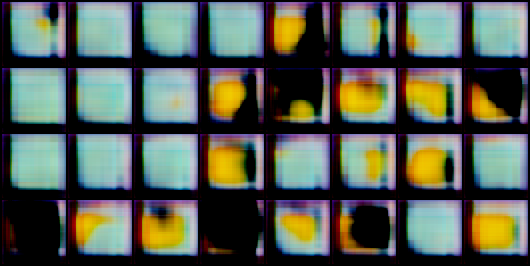

images/epoch28_generator.png


0
5544
Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 1 Summary
generator Mean Gradients : 8520.988662903346
discriminator Mean Gradients : 1829330.5171634217
Mean Running Discriminator Loss : 15.479504603486753
Mean Running Generator Loss : 15.086752110029492
Generating and Saving Images to ./images/epoch29_generator.png

Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 2 Summary
generator Mean Gradients : 8237.452279248299
discriminator Mean Gradients : 1768447.0258318135
Mean Running Discriminator Loss : 14.965307342207455
Mean Running Generator Loss : 14.689672971748251
Generating and Saving Images to ./images/epoch30_generator.png

Training of the Model is Complete
images/epoch29_generator.png


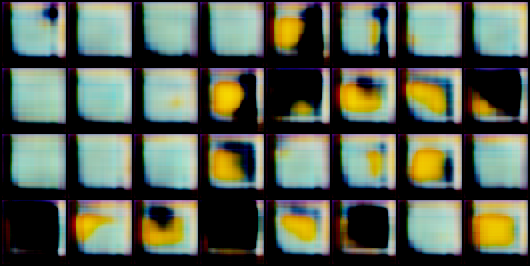

images/epoch30_generator.png


0
5544
Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 1 Summary
generator Mean Gradients : 7972.185971845996
discriminator Mean Gradients : 1711484.0948775255
Mean Running Discriminator Loss : 14.483982769234373
Mean Running Generator Loss : 14.322692239984766
Generating and Saving Images to ./images/epoch31_generator.png

Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 2 Summary
generator Mean Gradients : 7723.611193807167
discriminator Mean Gradients : 1658079.9617578727
Mean Running Discriminator Loss : 14.033009981950851
Mean Running Generator Loss : 13.978181600808785
Generating and Saving Images to ./images/epoch32_generator.png

Training of the Model is Complete
images/epoch31_generator.png


images/epoch32_generator.png


0
5544
Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 1 Summary
generator Mean Gradients : 7490.0736054715535
discriminator Mean Gradients : 1607907.7172206459
Mean Running Discriminator Loss : 13.609611268468283
Mean Running Generator Loss : 13.650340399040362
Generating and Saving Images to ./images/epoch33_generator.png

Saving Model at '/content/drive/My Drive/big_small__gan0.model'
Epoch 2 Summary
generator Mean Gradients : 7270.187253767056
discriminator Mean Gradients : 1560680.765638837
Mean Running Discriminator Loss : 13.210755356604901
Mean Running Generator Loss : 13.345088837842598
Generating and Saving Images to ./images/epoch34_generator.png

Training of the Model is Complete
images/epoch33_generator.png


images/epoch34_generator.png


0
5544


In [0]:
for i in range(100):
  trainer(church_loader(5500))
  img_show(i)

In [0]:
for i in range(1,60):
  path = 'images/epoch' + str(i) + '_generator.png'
  print(path)4=
  sample = cv2.imread(path)
  sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
  cv2_imshow(sample)